In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lasio
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [39]:
#read main logs in ft
main = lasio.read('./data/58-32_main.las')
dfmain = main.df()
#dfmain.info()

In [40]:
#read sonic logs in ft
sonic = lasio.read('./data/58-32_sonic.las')
dfsonicall = sonic.df()
dfsonicall['VpVs']= ((1/dfsonicall['DTCO'])/(1/dfsonicall['DTSM']))
dfsonic = dfsonicall[['DT1R','DT2','DT2R','DT4P','DT4S','DTCO','DTRP','DTRS','DTSM','ITT','PR','SPHI','VpVs']]
#dfsonic.info()

In [41]:
#merge main and sonic logs (not repeated curves) using pandas
all_logs = pd.concat([dfmain, dfsonic], axis=1, sort=False)
#all_logs.info()

#### Calculations based on publication "Well-log based prediction of thermal conductivity of sedimentary successions: a case study from the North German Basin. Fuchs, S., and Foster, A. Geophysical Journal International. 2014. 196, pg 291-311. doi: 10.1093/gji/ggt382

In [42]:
#calculate Vsh from GR formula Vsh=(subdata.GR_EDTC-grmin)/(grmax-grmin)
all_logs['Vsh'] = all_logs['GR'] - min(all_logs['GR'])/(max(all_logs['GR'])- min(all_logs['GR']))

#calculate NPHI matrix from NPHI porosity and DEN porosity neu_m=subdata.NPOR-subdata.DPHZ
all_logs['NPOR_m'] = (all_logs['NPOR']) - (all_logs['DPHZ'])   

#calculate eq10
#Matrix-TC equation derived from regression analysis for clastic rock types
all_logs['eq10'] = (5.281-(2.961*all_logs['NPOR_m'])-(2.797*all_logs['Vsh']))/-272.15

#calculate eq11
#Bulk-TC equation derived from regression analysis for subsurface data
all_logs['eq11'] = (4.75-(4.19*all_logs['NPOR'])-(1.81*all_logs['Vsh']))/-272.15

#all_logs.info()

In [43]:
#read discrete data - conversion to ft - depth equal to lower depth interval 
tops = pd.read_csv('./data/58-32_tops.csv')

#Thermal Conductivity 
TC_coredata = pd.read_csv ('./data/58-32_thermal_conductivity_data.csv') 
TC_coredata['Depth'] = (3.28084*TC_coredata['Lower Depth Interval (m)'])
TC_coredata['Matrix_TC']=TC_coredata['matrix thermal conductivity (W/m deg C)']
TC_coredata.set_index('Depth', inplace=True)

#XRD lab data
XRD_coredata = pd.read_csv ('./data/58-32_xray_diffraction_data.csv') 
XRD_coredata = XRD_coredata.replace('tr',0)
XRD_coredata['Depth'] = (3.28084*XRD_coredata['Lower Depth Range (m)'])
XRD_coredata.set_index('Depth', inplace=True)

#TC_coredata.tail(15)

In [44]:
#basic plot to inspect data 
def make_layout_tc (log_df, XRD, TC):
    
    import numpy as np
    import pandas as pd
    import matplotlib
    import matplotlib.pyplot as plt
  
    fig, axs = plt.subplots(nrows=1, ncols=6, sharey=True, squeeze=True, figsize=(15, 15), gridspec_kw={'wspace': 0.25})
    fig.subplots_adjust(left=0.05, bottom=0.05, right=0.975, top=0.7, wspace=0.2, hspace=0.2)
    axs[0].set_ylabel('Depth (ft)')
    axs[0].invert_yaxis()
    axs[0].get_xaxis().set_visible(False)
    
    # First track GR/SP/CALI logs to display
    ax1 = axs[0].twiny()  
    ax1.plot(log_df.GR, log_df.index, '-', color='#2ea869', linewidth=0.5)
    ax1.set_xlim(0,450) 
    ax1.set_xlabel('GR (API)', color='#2ea869')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.15)) 
    
    ax2 = axs[0].twiny() 
    ax2.plot(log_df.SP, log_df.index, '-', color='#0a0a0a', linewidth=0.7)
    ax2.set_xlim(-200,200) 
    ax2.set_xlabel('SP(mV)', color='#0a0a0a')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))    
      
    ax3 = axs[0].twiny() 
    ax3.plot(log_df.DCAL, log_df.index, '--', color='#9da4a1', linewidth=0.5)
    ax3.set_xlim(-5,15) 
    ax3.set_xlabel('DCAL (in)', color='#9da4a1')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[0].get_xaxis().set_visible(False)
    
    # Second track RHOB/NPHI/PEF logs to display
    ax1 = axs[1].twiny()  
    ax1.plot(log_df.RHOZ, log_df.index, '-', color='#ea0606', linewidth=0.5)
    ax1.set_xlim(1.5,3.0) 
    ax1.set_xlabel('RHOB (g/cm3)', color='#ea0606')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.15))

    ax2 = axs[1].twiny()  
    ax2.plot(log_df.NPHI, log_df.index, '-', color='#1577e0', linewidth=0.5)
    ax2.set_xlim(1,0) 
    ax2.set_xlabel('NPHI (v/v)', color='#1577e0')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))
    
    ax3 = axs[1].twiny()  
    ax3.plot(log_df.PEFZ, log_df.index, '-', color='#1acb20', linewidth=0.5)
    ax3.set_xlim(0,15) 
    ax3.set_xlabel('PEFZ (b/e)', color='#1acb20')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[1].get_xaxis().set_visible(False)
    
    # Third track Resistivities
    ax1 = axs[2].twiny()  
    ax1.plot(log_df.AT10, log_df.index, '-', color='#d6dbd7', linewidth=0.5)
    ax1.set_xlim(0.2,20000)  
    ax1.set_xlabel('AT10 (ohm.m)', color='#d6dbd7')
    ax1.set_xscale('log')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.15))
    
    ax2 = axs[2].twiny()  
    ax2.plot(log_df.AT30, log_df.index, '-', color='#0a0a0a', linewidth=0.5)
    ax2.set_xlim(0.2,20000)  
    ax2.set_xlabel('AT30 (ohm.m)', color='#0a0a0a')
    ax2.set_xscale('log')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))
    
    ax3 = axs[2].twiny()  
    ax3.plot(log_df.AT90, log_df.index, '-', color='#ea0606', linewidth=0.5)
    ax3.set_xlim(0.2,20000)  
    ax3.set_xlabel('AT90 (ohm.m)', color='#ea0606')
    ax3.set_xscale('log')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[2].get_xaxis().set_visible(False)

   # Forth track Sonic
    ax1 = axs[3].twiny()  
    ax1.plot(log_df.DTSM, log_df.index, '-', color='#9da4a1', linewidth=0.5)
    ax1.set_xlim(200,40) 
    ax1.set_xlabel('DTS (us/ft)', color='#9da4a1')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.15))
    
    ax2 = axs[3].twiny()  
    ax2.plot(log_df.DTCO, log_df.index, '-', color='#0a0a0a', linewidth=0.5)
    ax2.set_xlim(200,40) 
    ax2.set_xlabel('DTC (us/ft)', color='#0a0a0a')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))
    
    ax3 = axs[3].twiny()  
    ax3.plot(log_df.VpVs, log_df.index, '-', color='#e1093f', linewidth=0.5)
    ax3.set_xlim(1,3) 
    ax3.set_xlabel('VpVs (unitless)', color='#e1093f')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[3].get_xaxis().set_visible(False)


  # Fifth track XRD to display
    ax1 = axs[4].twiny()  
    ax1.plot(XRD.Quartz, XRD.index, 'o', color='#eac406')
    ax1.set_xlim(0,100) 
    ax1.set_xlabel('Quartz %', color='#eac406')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.15))

    ax2 = axs[4].twiny()  
    ax2.plot(XRD['K-feldspar'], XRD.index, 'o', color='#05a9f0')
    ax2.set_xlim(0,100) 
    ax2.set_xlabel('K-feldspar %', color='#05a9f0')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.075))
    
    ax3 = axs[4].twiny()  
    ax3.plot(XRD['Illite'], XRD.index, 'o', color='#94898c')
    ax3.set_xlim(0,100) 
    ax3.set_xlabel('Illite %', color='#94898c')
    ax3.minorticks_on()
    ax3.spines['top'].set_position(('axes', 1.0))
    ax3.grid(True)
    axs[4].get_xaxis().set_visible(False)


    # Sixth track Temp/TC to display
    ax1 = axs[5].twiny()  
    ax1.plot(TC.Matrix_TC, TC.index, 'o', color='#6e787c')
    ax1.set_xlim(0,5) 
    ax1.set_xlabel('Matrix TC Measured W/mC', color='#6e787c')
    ax1.minorticks_on()
    ax1.spines['top'].set_position(('axes', 1.075))

    ax2 = axs[5].twiny()  
    ax2.plot(log_df.CTEM, log_df.index, '-', color='#ed8712')
    ax2.set_xlim(0,300) 
    ax2.set_xlabel('Temp degF', color='#ed8712')
    ax2.minorticks_on()
    ax2.spines['top'].set_position(('axes', 1.0))
    ax2.grid(True)
    axs[5].get_xaxis().set_visible(False)
         
    fig.suptitle('Well Data for UTAH FORGE 58-32',weight='bold', fontsize=20, y=0.9);
    plt.show()


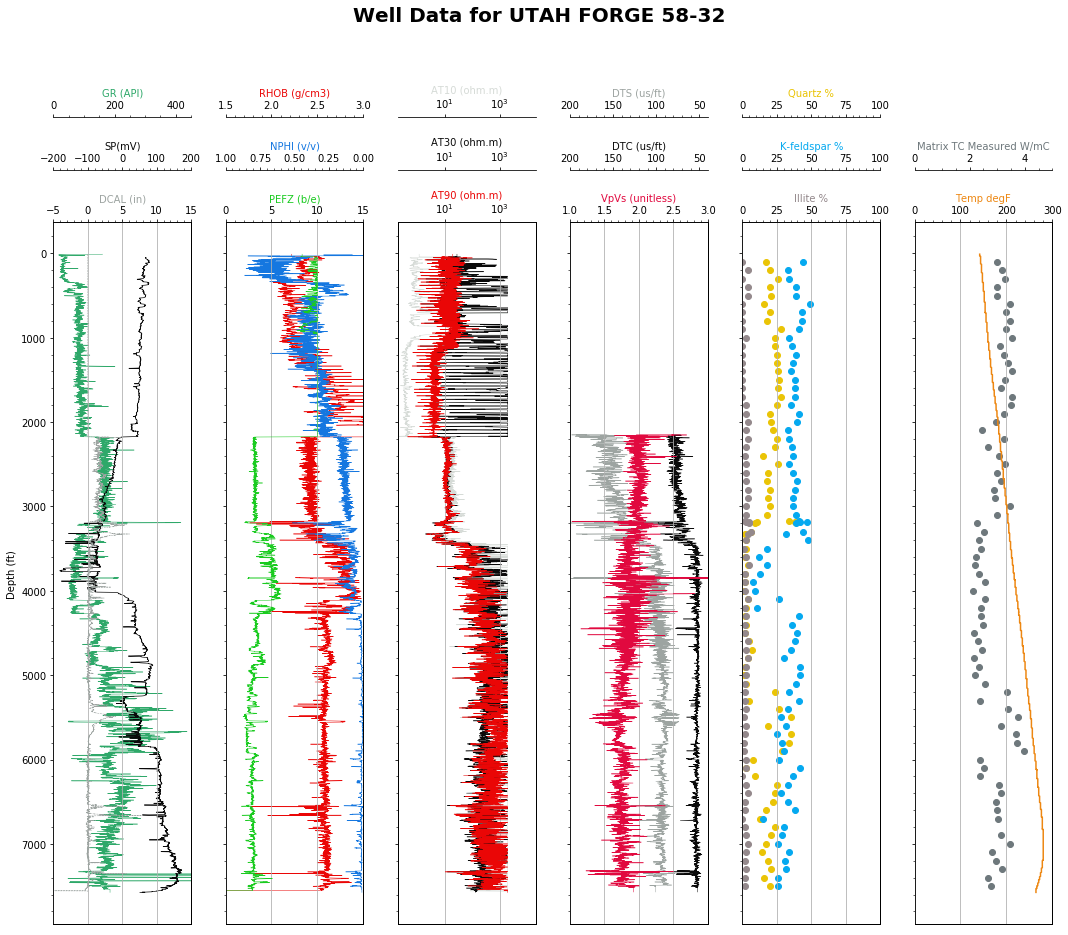

In [45]:
make_layout_tc (all_logs, XRD_coredata, TC_coredata)

In [46]:
all_logs.to_csv('./data/all_logs.csv')